In [1]:
# run stopwatch
from tools import Stopwatch
stopwatch = Stopwatch()
start = stopwatch.start()

### Load libraries, functions, palette, theme

In [2]:
%run _libraries.ipynb

In [3]:
%run _functions.ipynb

In [4]:
dir_current = '03-arima-month'

In [5]:
dir_save_files = 'files/'

In [6]:
dir_load_files = 'files/'

In [7]:
dir_save_img = 'docs/img/'

In [8]:
session_name = dir_current

# Section III. ARIMA

## Load Saved Section if exists

## Load Data

In [9]:
train = loadit('train_preprocessed', dir=dir_load_files)

In [10]:
valid = loadit('valid_preprocessed', dir=dir_load_files)

In [11]:
test = loadit('test_preprocessed', dir=dir_load_files)

In [12]:
target = 'target1'

In [13]:
features = ['is_Friday', 'is_Sunday', 'is_31', 'target1_previous_month']

## Naive Models

### First Naive Model

##### Predictions

In [14]:
y_pred_naive_first = valid[target].shift(1)[1:].copy()

In [15]:
y_true_naive_first = valid[target][1:].copy()

##### R-squared

In [16]:
round(r2_score(y_true_naive_first, y_pred_naive_first), 3)

0.99

##### MAE

In [17]:
math.ceil(mean_absolute_error(y_true_naive_first, y_pred_naive_first))

468

##### MAPE

In [18]:
round(mean_absolute_percentage_error(y_true_naive_first, y_pred_naive_first) * 100, 2)

1.33

##### RMSE

In [19]:
math.ceil(root_mean_squared_error(y_true_naive_first, y_pred_naive_first))

697

### Second Naive Model

##### Predictions

In [20]:
y_pred_naive_second = valid['target1_previous_month'].copy()

In [21]:
y_true_naive_second = valid[target].copy()

##### R-squared

In [22]:
round(r2_score(y_true_naive_second, y_pred_naive_second), 3)

0.746

##### MAE

In [23]:
math.ceil(mean_absolute_error(y_true_naive_second, y_pred_naive_second))

2763

##### MAPE

In [24]:
round(mean_absolute_percentage_error(y_true_naive_second, y_pred_naive_second) * 100, 2)

7.68

##### RMSE

In [25]:
math.ceil(root_mean_squared_error(y_true_naive_second, y_pred_naive_second))

3558

## Stationarity

p< 0.05: Enough evidence to say, that process is stationarity

In [26]:
# NULL: non-stationarity
sm.tsa.stattools.adfuller(train[target])

(-28.686047970170506,
 0.0,
 47,
 30480,
 {'1%': -3.4305645620343594,
  '5%': -2.8616348306743395,
  '10%': -2.566820475464527},
 460471.5647015386)

In [27]:
train['month'].unique()

array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [28]:
for i in train['month'].unique():
    print(sm.tsa.stattools.adfuller(train.loc[train['month']==i, target])[1])
    print(sm.tsa.stattools.adfuller(train.loc[train['month']==i, target])[1] < 0.05)

1.0644033759839667e-22
True
3.732657699349194e-20
True
7.432116387741869e-24
True
1.7428395333340719e-23
True
2.955844723407367e-22
True
4.44900636796093e-19
True
8.442519583711138e-20
True


In [29]:
for i in train['month'].unique():
    print(sm.tsa.stattools.adfuller(train.loc[train['month']==i, target].diff()[1:])[1])
    print(sm.tsa.stattools.adfuller(train.loc[train['month']==i, target].diff()[1:])[1] < 0.05)

4.97351764764749e-26
True
4.483001520404638e-24
True
6.141089115772981e-28
True
3.702018465634753e-28
True
1.1368337132320429e-27
True
5.506358370607743e-23
True
1.2150033480795901e-26
True


## Autocorrelation

### Datasets

Train: July data;  
Validation: August data.

In [30]:
y = train.loc['2017-03', target].copy()

In [31]:
y

2017-03-01 00:00:00    29069.61702
2017-03-01 00:10:00    28579.40426
2017-03-01 00:20:00    27844.08511
2017-03-01 00:30:00    27237.44681
2017-03-01 00:40:00    26882.04255
                          ...     
2017-03-31 23:10:00    33052.59574
2017-03-31 23:20:00    32292.76596
2017-03-31 23:30:00    31042.72340
2017-03-31 23:40:00    30025.53191
2017-03-31 23:50:00    29339.23404
Freq: 10min, Name: target1, Length: 4464, dtype: float64

#### ACF - 40 period

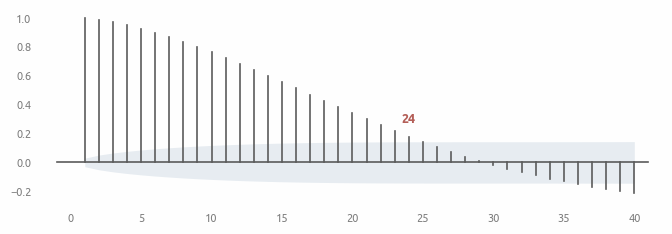

In [32]:
fig = plt.figure()
plot_acf(data=y, lags=40)

In [33]:
ts_acf_last_significant_index(y)

24

#### ACF - 300 period

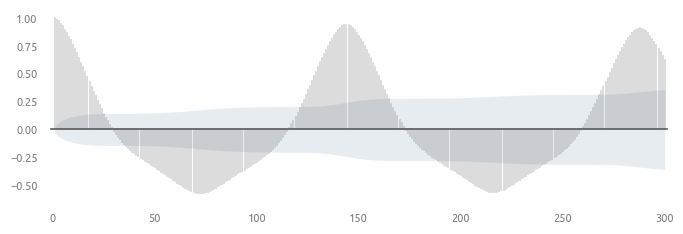

Images 'ACF_300.png' and 'ACF_300.svg' successfully saved into 'docs/img/' directory


In [34]:
fig = plt.figure()
plot_acf(data=y, lags=300, transparency_lines=0.25, show_last_significant=False)
plt.show()
savefig('ACF_300', dir_save_img)

#### PACF - 36 period

In [35]:
pacf = ts_acf_calculate(y, lags=36, partial=True)

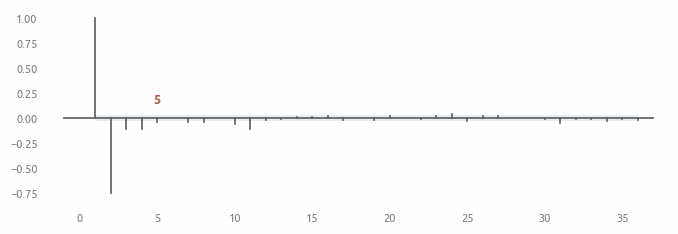

Images 'PACF.png' and 'PACF.svg' successfully saved into 'docs/img/' directory


In [36]:
fig = plt.figure()
plot_acf(data=y, lags=36, last_significant_delta=0.175, partial=True)
plt.show()
savefig('PACF', dir_save_img)

## Cross-validation Schema

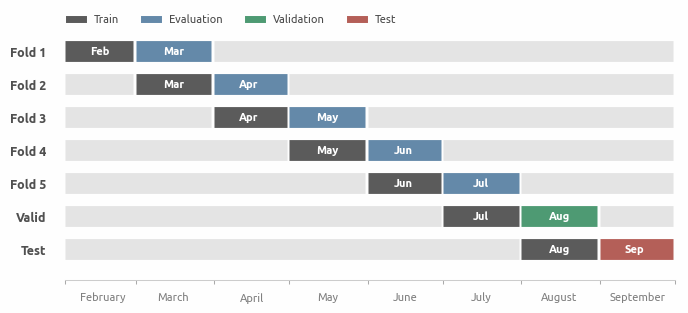

Images 'cv_schema.png' and 'cv_schema.svg' successfully saved into 'docs/img/' directory


In [37]:
train_start = dt.datetime(2017,2,1)
back_start = dt.datetime(2017,2,1)
forward_finish = dt.datetime(2017,9,30)
lw=15
k_ = 0

fig = plt.figure(figsize=(8, 3))
ax=ax_current()

for i in arange(7):
    back_finish = train_start - dt.timedelta(days=1)
    ev_start = dt.datetime(2017, train_start.month+1, 1)
    forward_start = dt.datetime(2017, train_start.month+2, 1)
    train_finish = \
        dt.datetime(2017, train_start.month+1, 1) - dt.timedelta(days=1)
    ev_finish = \
        dt.datetime(2017, train_start.month+2, 1) - dt.timedelta(days=1)
    
    range_back = pd.date_range(back_start, back_finish, freq='d')
    range_train = pd.date_range(train_start, train_finish, freq='d')
    range_ev = pd.date_range(ev_start, ev_finish, freq='d')
    range_forward = pd.date_range(forward_start, forward_finish, freq='d')

    len_train = (train_finish - train_start).days
    len_ev = (ev_finish - ev_start).days

    color_back = color_forward = alpha_color(palette[-1], 0.4)
    color_ev = alpha_color(palette[2], 1)
    
    if i == 5:
        color_ev = palette[3]
    if i == 6:
        color_ev = palette[1]

    ax.plot(
        range_back,
        [7-i]*len(range_back),
        lw=lw,
        solid_capstyle='butt',
        color=color_back)

    ax.plot(
        range_train,
        [7-i]*len(range_train),
        lw=lw,
        solid_capstyle='butt',
        color=palette[0])

    ax.plot(
        range_ev,
        [7-i]*len(range_ev),
        lw=lw,
        solid_capstyle='butt',
        color=color_ev)

    ax.plot(
        range_forward,
        [7-i]*len(range_forward),
        lw=lw,
        solid_capstyle='butt',
        color=color_forward)
    
    ax.annotate(
        train_start.strftime("%B")[:3],
        xy=(dt.datetime(2017, train_start.month,
                        int(round(len_train/2))+1), 7-i-0.1),
        ha='center',
        color='white',
        weight='bold',
        size=8)

    ax.annotate(
        ev_start.strftime("%B")[:3],
        xy=(dt.datetime(2017, ev_start.month,
                        int(round(len_ev/2))+1), 7-i-0.1),
        ha='center',
        color='white',
        weight='bold',
        size=8)
    
    train_start = dt.datetime(2017, train_start.month+1, 1)

ax.legend(
    **legend_create_handles(
        n=4, kind='rect',
        labels=['Train', 'Evaluation', 'Validation', 'Test'],
        colors=[palette[0], alpha_color(palette[2], 1),
                palette[3], palette[1]], alpha=1),
    **legend_inline())

axis_rstyle(
    y_axis_hide=True, x_ticks_hide=True, offset_left=0)

ax_sec = ax.secondary_xaxis('bottom')
ax_sec.set_xticks(ax.get_xticks())
ax_sec.spines['bottom'].set_visible(False)
ax_sec.spines['bottom'].set_position(('outward', 13))
ax_sec.tick_params(axis='x', labelbottom=False, size=3)

ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%B'))
ax.xaxis.set_major_locator(mpl.dates.DayLocator(bymonthday=16))

ax.set_yticks(
    ticks=arange(1, 8),
    labels=[
        'Test', 'Valid', 'Fold 5', 'Fold 4',
        'Fold 3', 'Fold 2', 'Fold 1'],
    fontsize=9,
    weight='bold',
    color=palette[0]
)
ax.tick_params(axis='y', colors='#505050')

ax.set_ylim(0.5, 7.5)

plt.show()
savefig('cv_schema', dir_save_img)

In [38]:
len(train.loc['2017-03-01':]['month'].unique())

5

In [39]:
cv_indexes_train, cv_indexes_eval = cv_split_indexes(
    data=train['target1'], start='2017-03-01', train_size=1,
    test_size=1, size_unit='months', n_splits=5, freq='10min')

In [40]:
cv_indexes_train[0]

DatetimeIndex(['2017-02-01 00:00:00', '2017-02-01 00:10:00',
               '2017-02-01 00:20:00', '2017-02-01 00:30:00',
               '2017-02-01 00:40:00', '2017-02-01 00:50:00',
               '2017-02-01 01:00:00', '2017-02-01 01:10:00',
               '2017-02-01 01:20:00', '2017-02-01 01:30:00',
               ...
               '2017-02-28 22:20:00', '2017-02-28 22:30:00',
               '2017-02-28 22:40:00', '2017-02-28 22:50:00',
               '2017-02-28 23:00:00', '2017-02-28 23:10:00',
               '2017-02-28 23:20:00', '2017-02-28 23:30:00',
               '2017-02-28 23:40:00', '2017-02-28 23:50:00'],
              dtype='datetime64[ns]', length=4032, freq='10min')

In [41]:
cv_indexes_eval[0]

DatetimeIndex(['2017-03-01 00:00:00', '2017-03-01 00:10:00',
               '2017-03-01 00:20:00', '2017-03-01 00:30:00',
               '2017-03-01 00:40:00', '2017-03-01 00:50:00',
               '2017-03-01 01:00:00', '2017-03-01 01:10:00',
               '2017-03-01 01:20:00', '2017-03-01 01:30:00',
               ...
               '2017-03-31 22:20:00', '2017-03-31 22:30:00',
               '2017-03-31 22:40:00', '2017-03-31 22:50:00',
               '2017-03-31 23:00:00', '2017-03-31 23:10:00',
               '2017-03-31 23:20:00', '2017-03-31 23:30:00',
               '2017-03-31 23:40:00', '2017-03-31 23:50:00'],
              dtype='datetime64[ns]', length=4464, freq='10min')

In [42]:
cv_indexes_train[-1]

DatetimeIndex(['2017-06-01 00:00:00', '2017-06-01 00:10:00',
               '2017-06-01 00:20:00', '2017-06-01 00:30:00',
               '2017-06-01 00:40:00', '2017-06-01 00:50:00',
               '2017-06-01 01:00:00', '2017-06-01 01:10:00',
               '2017-06-01 01:20:00', '2017-06-01 01:30:00',
               ...
               '2017-06-30 22:20:00', '2017-06-30 22:30:00',
               '2017-06-30 22:40:00', '2017-06-30 22:50:00',
               '2017-06-30 23:00:00', '2017-06-30 23:10:00',
               '2017-06-30 23:20:00', '2017-06-30 23:30:00',
               '2017-06-30 23:40:00', '2017-06-30 23:50:00'],
              dtype='datetime64[ns]', length=4320, freq='10min')

In [43]:
cv_indexes_eval[-1]

DatetimeIndex(['2017-07-01 00:00:00', '2017-07-01 00:10:00',
               '2017-07-01 00:20:00', '2017-07-01 00:30:00',
               '2017-07-01 00:40:00', '2017-07-01 00:50:00',
               '2017-07-01 01:00:00', '2017-07-01 01:10:00',
               '2017-07-01 01:20:00', '2017-07-01 01:30:00',
               ...
               '2017-07-31 22:20:00', '2017-07-31 22:30:00',
               '2017-07-31 22:40:00', '2017-07-31 22:50:00',
               '2017-07-31 23:00:00', '2017-07-31 23:10:00',
               '2017-07-31 23:20:00', '2017-07-31 23:30:00',
               '2017-07-31 23:40:00', '2017-07-31 23:50:00'],
              dtype='datetime64[ns]', length=4464, freq='10min')

## Choose AR, I, MA parameters

### Cross-validation 0: AR, I, MA parameters

5-Fold CV:

- All combinations from 1 to 6 for AR and MA parameters  
- 0 and 1 for I parameter

In [ ]:
%%time
cv0_results_dict = {}
# for all combinations of (1,1), (1,2), (1,3) ... (6,6)
for i in [0, 1]:
    for arma in itertools.product(arange(1,6,True), repeat=2):
        
        order = (arma[0], i, arma[1])
        model_name = f'ARIMA {order}'
        rmse0_list = []
        
        for idx_train, idx_eval in zip(cv_indexes_train, cv_indexes_eval):
            
            rmse0_local = cv_arima_evaluation(
                data_train=train.loc[idx_train, target],
                data_eval=train.loc[idx_eval, target],
                order=order,
                metric=root_mean_squared_error,
                exec_time=False,
                clear_output=False)
            
            rmse0_list.append(rmse0_local)
            
        cv0_results_dict[model_name] = rmse0_list
        print(f'Evaluation of model ARIMA ({order}) is finished')
        
clear_output()

Evaluation of model ARIMA ((1, 0, 1)) is finished
Evaluation of model ARIMA ((1, 0, 2)) is finished
Evaluation of model ARIMA ((1, 0, 3)) is finished
Evaluation of model ARIMA ((1, 0, 4)) is finished
Evaluation of model ARIMA ((1, 0, 5)) is finished
Evaluation of model ARIMA ((1, 0, 6)) is finished
Evaluation of model ARIMA ((2, 0, 1)) is finished
Evaluation of model ARIMA ((2, 0, 2)) is finished
Evaluation of model ARIMA ((2, 0, 3)) is finished
Evaluation of model ARIMA ((2, 0, 4)) is finished
Evaluation of model ARIMA ((2, 0, 5)) is finished
Evaluation of model ARIMA ((2, 0, 6)) is finished
Evaluation of model ARIMA ((3, 0, 1)) is finished


/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/achas

Evaluation of model ARIMA ((3, 0, 2)) is finished
Evaluation of model ARIMA ((3, 0, 3)) is finished


/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Evaluation of model ARIMA ((3, 0, 4)) is finished


/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Evaluation of model ARIMA ((3, 0, 5)) is finished
Evaluation of model ARIMA ((3, 0, 6)) is finished


In [ ]:
cv0_results_df = pd.DataFrame(cv0_results_dict)

In [ ]:
cv0_results_df.mean().sort_values().head(40)

In [ ]:
arima415 = SARIMAX(
    endog=y, exog=None,
    order=(4,1,5),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [ ]:
print(arima415.summary())

In [ ]:
arima211 = SARIMAX(
    endog=y, exog=None,
    order=(2,1,1),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [ ]:
print(arima211.summary())

In [ ]:
plt.scatter(
    x=cv0_results_df['ARIMA (4, 1, 5)'].index,
    y=cv0_results_df['ARIMA (4, 1, 5)'],
    s=50,
    zorder=10,
    lw=0.5)
plt.plot(
    smoothed(cv0_results_df['ARIMA (4, 1, 5)'], n=50, k=2), label='ARIMA (4,1,5)')
plt.scatter(
    x=cv0_results_df['ARIMA (2, 1, 1)'].index,
    y=cv0_results_df['ARIMA (2, 1, 1)'],
    s=50,
    lw=0.5)
plt.plot(
    smoothed(cv0_results_df['ARIMA (2, 1, 1)'], n=50, k=2), label='ARIMA (2,1,1)')

axis_rstyle(xticks=[0,4,1], yticks=[6500, 8500, 500], ylim=[6500, 8600])
plt.legend(**legend_inline())
plt.xlabel('Folds - Evaluation month', labelpad=20)
plt.ylabel('RMSE')

ax_sec = axis_secondary(ax=ax_current(), pad=30)
ax_sec.set_xticks(arange(5), months_list[2:7])

plt.show()

In [ ]:
# should plot resid[d:], where d is d-order of ARIMA model
plot_acf(data=arima415.resid[1:])

## Managing seasonality

### Fourier transform

In [ ]:
y_values = train.loc['2017-05', target].values

In [ ]:
y_values_trend = scipy.signal.savgol_filter(y_values, 25, 1)

In [ ]:
y_values_detrended = y_values - y_values_trend

In [ ]:
fft_x = np.fft.fftfreq(len(y_values_detrended))
fft_x = fft_x[:len(fft_x)//2]

In [ ]:
fft_y = np.fft.fft(y_values_detrended)
fft_y = np.abs(fft_y[:len(fft_y)//2])

In [ ]:
fft_y_peaks_indices = get_peaks_indicies(fft_y, boundary=500000)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

plt.subplot(2, 1, 1)
plt.plot(fft_x, fft_y)
for idx in fft_y_peaks_indices:
    x_, y_ = fft_x[idx], fft_y[idx]
    text = f'{round(1/x_)}'
    plt.annotate(text, (x_, y_+300000), ha='center', size=8)
    plt.scatter(
        fft_x[idx], fft_y[idx],
        color=saturate_color(palette[1], 1.5), marker='.', s=20, zorder=10)

plt.title('Periods')
plt.xlim(0, 0.1)
plt.ylim(0, 3000000)
axis_rstyle(y_axis_hide=True, y_ticklabels_hide=True, x_ticklabels_hide=True, x_ticks_hide=True)

plt.subplot(2, 1, 2)
plt.plot(fft_x, fft_y)
for idx in fft_y_peaks_indices:
    x_, y_ = fft_x[idx], fft_y[idx]
    text = f'{round(1/x_/6)} h'
    plt.annotate(text, (x_, y_+300000), ha='center', size=8)
    plt.scatter(
        fft_x[idx], fft_y[idx],
        color=saturate_color(palette[1], 1.5), marker='.', s=20, zorder=10)

plt.title('Hours')
plt.xlim(0, 0.1)
plt.ylim(0, 3000000)
axis_rstyle(y_axis_hide=True, y_ticklabels_hide=True, x_ticklabels_hide=True, x_ticks_hide=True)

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('fourier_transform', dir_save_img)

### Cross-validation 1: Fourier period and order

5-Fold CV:

- Models: ARIMA (4,1,5), ARIMA (2,1,1)
- Periods: all combinations from 144 to (144, 72, 48, 36)
- Orders: 2 to 4 (equal orders, without conbinations)

Explore optimal Fourier period and order

In [ ]:
cv_indexes_train[0]

In [ ]:
cv_indexes_eval[0]

In [ ]:
cv_indexes_train[-1]

In [ ]:
cv_indexes_eval[-1]

In [ ]:
fourier_periods = [
    [144],
    [144, 72],
    [144, 72, 48],
    [144, 72, 48, 36]
]

In [ ]:
fourier_orders = [2, 3, 4]

In [ ]:
model_orders = [
    (2, 1, 1),
    (4, 1, 5)
]

In [ ]:
%%time

cv1_results_dict = {}
for order in model_orders:
    for f_period in fourier_periods:
        for fourier_order in fourier_orders:
            f_order = [fourier_order] * len(f_period)
            model_name = f'ARIMA {order} {tuple(f_period)} {tuple(f_order)}'
            rmse1_list = []
            
            for idx_train, idx_eval in zip(cv_indexes_train, cv_indexes_eval):

                train_data = train.loc[idx_train, target]
                eval_data = train.loc[idx_eval, target]

                train_w_exogs, eval_w_exogs = \
                    datasets_w_fourier(
                        fourier_period=f_period,
                        fourier_order=f_order,
                        train_data=train_data,
                        eval_data=eval_data,
                        train_exog=train.loc[idx_train, features],
                        eval_exog=train.loc[idx_eval, features])      

                rmse1_local = cv_arima_evaluation(
                    data_train=train_data,
                    data_eval=eval_data,
                    order=order,
                    exog_train=train_w_exogs,
                    exog_eval=eval_w_exogs,
                    metric=root_mean_squared_error,
                    exec_time=False,
                    clear_output=False)

                rmse1_list.append(rmse1_local)

            cv1_results_dict[model_name] = rmse1_list
            print(f'Evaluation of model {model_name} is finished')

clear_output()

In [ ]:
cv1_results_df = pd.DataFrame(cv1_results_dict)

In [ ]:
cv1_results_df

In [ ]:
cv1_results_mean = cv1_results_df.mean(axis=0)

In [ ]:
cv1_results_mean_std = cv1_results_df.std()

In [ ]:
cv1_results_mean.sort_values()

In [ ]:
cv1_results_arima415_mean = cv1_results_df.iloc[:, :12].mean(axis=0)

In [ ]:
cv1_results_arima415_mean.sort_values()

In [ ]:
cv1_results_arima211_mean = cv1_results_df.iloc[:, 12:].mean(axis=0)

In [ ]:
cv1_results_arima211_mean.sort_values()

In [ ]:
cv1_results_plot_labels = [i[16:] for i in cv1_results_mean.index]

In [ ]:
cv1_results_best_model = cv1_results_mean.sort_values().index[0]
cv1_results_best_model_index = \
    list(cv1_results_mean.index).index(cv1_results_best_model)

In [ ]:
cv1_results_second_best_model = cv1_results_mean.sort_values().index[1]
cv1_results_second_best_model_index = \
    list(cv1_results_mean.index).index(cv1_results_second_best_model)

In [ ]:
plt.figure(figsize=(9, 2.5))

plt.plot(smoothed(cv1_results_mean.values), lw=0.75, alpha=0.25)
plt.scatter(
    x=arange(len(cv1_results_mean)),
    y=cv1_results_mean, s=95, lw=1.5, clip_on=False, zorder=10)

plt.scatter(
    cv1_results_best_model_index,
    cv1_results_mean[cv1_results_best_model],
    s=40, color=palette[1],
    label=f'Best model: {cv1_results_best_model}',
    clip_on=False, zorder=100)

plt.scatter(
    cv1_results_second_best_model_index,
    cv1_results_mean[cv1_results_second_best_model],
    s=40, color=palette[3],
    label=f'Second best model: {cv1_results_second_best_model}',
    clip_on=False, zorder=100)

plt.errorbar(
    x=arange(len(cv1_results_mean)),
    y=cv1_results_mean,
    yerr=cv1_results_mean_std,
    c=palette[-1],
    linestyle='none',
    elinewidth=0.75,
    capsize=1,
    ecolor=palette[-3],
    # alpha=0.75,
    zorder=1)

plt.errorbar(
    x=cv1_results_best_model_index,
    y=cv1_results_mean.loc[cv1_results_best_model],
    yerr=cv1_results_mean_std.loc[cv1_results_best_model],
    c=palette[1],
    linestyle='none',
    elinewidth=1,
    capsize=1,
    ecolor=palette[1],
    # alpha=0.75,
    zorder=12)

plt.errorbar(
    x=cv1_results_second_best_model_index,
    y=cv1_results_mean.loc[cv1_results_second_best_model],
    yerr=cv1_results_mean_std.loc[cv1_results_second_best_model],
    c=palette[1],
    linestyle='none',
    elinewidth=1,
    capsize=1,
    ecolor=palette[3],
    # alpha=0.75,
    zorder=12)

axis_rstyle(
    offset_left=10,
    ylim=[0, 10000],
    yticks=[0, 10000, 2000],
    xlim=[0, len(cv1_results_mean)],
    x_spine_lim=[0, len(cv1_results_mean)-1])

plt.xticks(
    ticks=arange(len(cv1_results_mean)),
    labels=cv1_results_plot_labels, rotation=30, ha='right')

plt.legend(**legend_inline())

plt.show()

In [ ]:
plt.plot(
    smoothed(cv1_results_df[cv1_results_best_model]),
    lw=0.5, color=palette[0], alpha=0.25)
plt.scatter(
    x=cv1_results_df.index,
    y=cv1_results_df[cv1_results_best_model],
    s=25, color=palette[1], zorder=10,
    label=f'Best model: {cv1_results_best_model}',)

plt.plot(
    smoothed(cv1_results_df[cv1_results_second_best_model]),
    lw=0.5, color=palette[0], alpha=0.25)
plt.scatter(
    x=cv1_results_df.index,
    y=cv1_results_df[cv1_results_second_best_model],
    s=25, color=saturate_color(palette[3], 1.5), zorder=9,
    label=f'Second best model: {cv1_results_second_best_model}')

plt.plot(
    smoothed(cv1_results_df['ARIMA (2, 1, 1) (144, 72) (2, 2)']),
    lw=0.5, color=palette[0], alpha=0.25)
plt.scatter(
    x=cv1_results_df.index,
    y=cv1_results_df['ARIMA (2, 1, 1) (144, 72) (2, 2)'],
    s=25, color=saturate_color(palette[2], 1.5), zorder=11,
    label=f'Most stable model: ARIMA (2, 1, 1) (144, 72) (2, 2)')

axis_rstyle(xticks=[0,4,1])
ax_sec = axis_secondary(ax=ax_current(), pad=30)
ax_sec.set_xticks(arange(5), months_list[2:7])

plt.legend(**legend_inline(2))

plt.show()

### Cross-validation 2: Fourier orders for best model

5-Fold CV:

- Model: ARIMA (2,1,1)(144)
- Orders: 2 to 8 (equal orders, without comvinations)

Explore the effect of larger Fourier order on best model

In [ ]:
cv1_results_best_model

In [ ]:
cv1_results_best_model_order_str = \
    cv1_results_best_model[
        index_for_occurrence(cv1_results_best_model, '(', 1): \
        index_for_occurrence(cv1_results_best_model, ')', 1)+1
    ]

In [ ]:
cv1_results_best_model_order = (
    int(cv1_results_best_model_order_str[1]), 
    int(cv1_results_best_model_order_str[4]), 
    int(cv1_results_best_model_order_str[7])
)

In [ ]:
cv1_results_best_model_f_period_str = \
    cv1_results_best_model[
        index_for_occurrence(cv1_results_best_model, '(', 2)+1: \
        index_for_occurrence(cv1_results_best_model, ')', 2)
    ]

In [ ]:
if cv1_results_best_model_f_period_str[-1] == ',':
    cv1_results_best_model_f_period = [int(cv1_results_best_model_f_period_str[:-1])]
else:
    cv1_results_best_model_f_period = \
        [int(i) for i in cv1_results_best_model_f_period_str.split(',')]

In [ ]:
cv1_results_best_model_f_order_str = \
    cv1_results_best_model[
        index_for_occurrence(cv1_results_best_model, '(', 3)+1: \
        index_for_occurrence(cv1_results_best_model, ')', 3)
    ]

In [ ]:
if cv1_results_best_model_f_order_str[-1] == ',':
    cv1_results_best_model_f_order = [int(cv1_results_best_model_f_order_str[:-1])]
else:
    cv1_results_best_model_f_order = \
        [int(i) for i in cv1_results_best_model_f_order_str.split(',')]

In [ ]:
%%time

if len(cv1_results_best_model_f_order) == 1:
    
    cv1_results_best_model_f_order_fin = cv1_results_best_model_f_order[0] + 5
    cv2_fourier_orders = \
        arange(cv1_results_best_model_f_order[0], cv1_results_best_model_f_order_fin)

    cv2_results_dict = {}
    for fourier_order in cv2_fourier_orders:
        
        f_order = [fourier_order]
        model_name_1 = cv1_results_best_model_order
        model_name_2 = tuple(cv1_results_best_model_f_period)
        model_name_3 = tuple(f_order)
        model_name = f'ARIMA {model_name_1} ({model_name_2}) {model_name_3}'
        rmse2_list = []
        
        for idx_train, idx_eval in zip(cv_indexes_train, cv_indexes_eval):
    
            train_data = train.loc[idx_train, target]
            eval_data = train.loc[idx_eval, target]

            train_w_exogs, eval_w_exogs = \
                datasets_w_fourier(
                    fourier_period=f_period,
                    fourier_order=f_order,
                    train_data=train_data,
                    eval_data=eval_data,
                    train_exog=train.loc[idx_train, features],
                    eval_exog=train.loc[idx_eval, features])            
    
            rmse2_local = cv_arima_evaluation(
                data_train=train_data,
                data_eval=eval_data,
                order=cv1_results_best_model_order,
                exog_train=train_w_exogs,
                exog_eval=eval_w_exogs,
                metric=root_mean_squared_error,
                exec_time=False,
                clear_output=False)
            
            rmse2_list.append(rmse2_local)
    
        cv2_results_dict[model_name] = rmse2_list
        print(f'Evaluation of model {model_name} is finished')
    
    clear_output()

In [ ]:
cv2_results_df = pd.DataFrame(cv2_results_dict)

In [ ]:
cv2_results_df

In [ ]:
cv2_results_df.mean().sort_values()

### Cross-validation 3: Fourier period increase and orders research

5-Fold CV:

- Model: ARIMA (2,1,1)
- Fourier periods: [144], [144, 72], [144, 72, 48],
- Orders: 4 to 6 (all conbinations)

Explore the effect of combinations Fourier order on best model

In [ ]:
model_orders = [(2,1,1)]

In [ ]:
fourier_periods = [[144, 72], [144, 72, 48]]

In [ ]:
fourier_orders = arange(4,6,True)

In [ ]:
%%time

cv3_results_dict = {}
for order in model_orders:
    for f_period in fourier_periods:
        for f_order in itertools.product(fourier_orders, repeat=len(f_period)):
            
            model_name = f'ARIMA {order} {tuple(f_period)} {tuple(f_order)}'
            rmse3_list = []
            
            for idx_train, idx_eval in zip(cv_indexes_train, cv_indexes_eval):

                train_data = train.loc[idx_train, target]
                eval_data = train.loc[idx_eval, target]

                train_w_exogs, eval_w_exogs = \
                    datasets_w_fourier(
                        fourier_period=f_period,
                        fourier_order=f_order,
                        train_data=train_data,
                        eval_data=eval_data,
                        train_exog=train.loc[idx_train, features],
                        eval_exog=train.loc[idx_eval, features])

                rmse3_local = cv_arima_evaluation(
                    data_train=train_data,
                    data_eval=eval_data,
                    order=order,
                    exog_train=train_w_exogs,
                    exog_eval=eval_w_exogs,
                    metric=root_mean_squared_error,
                    exec_time=False,
                    clear_output=False)

                rmse3_list.append(rmse3_local)

            cv3_results_dict[model_name] = rmse3_list
            print(f'Evaluation of model {model_name} is finished')

clear_output()

In [ ]:
cv3_results_df = pd.DataFrame(cv3_results_dict)

In [ ]:
cv3_results_df

In [98]:
cv1_results_month_model = loadit('month_model_cv1_results', dir_load_files)

In [99]:
cv1_month_models = cv1_results_month_model['models'].copy()

In [100]:
cv1_month_splits = pd.DataFrame(cv1_results_month_model['splits'])

In [101]:
cv1_month_splits

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,...,model246,model247,model248,model249,model250,model251,model252,model253,model254,model255
0,2141.209691,2223.825393,2210.151980,2223.067808,2052.666621,2115.503357,2102.707255,2109.854159,2133.883996,2201.183992,...,2101.080669,2108.629155,2196.935842,2197.471618,2176.479063,2184.510255,2176.376046,2177.751551,2170.883332,2182.076367
1,2153.798884,2077.102021,2059.467957,2058.906914,2196.794515,2098.098537,2059.109933,2054.328307,2321.148557,2191.175668,...,2060.824191,2054.879881,2190.124971,2190.439577,2126.715430,2119.569698,2126.561508,2126.686483,2127.203985,2119.369038
2,2766.906284,2671.805914,2675.423138,2690.244024,3197.415119,3017.025863,3027.591204,3064.326692,3138.726821,2941.658115,...,2777.432794,2809.180356,2708.114610,2707.789281,2715.259190,2741.113742,2715.459103,2715.110036,2714.376479,2739.392339
3,6080.315428,6254.590535,6159.583086,6097.543049,5751.389423,5904.554664,5821.292968,5768.814349,5971.742674,6127.996341,...,5822.149270,5770.658512,6125.505541,6124.837732,6041.947523,5993.468320,6041.726154,6041.032632,6033.694287,5985.654007
4,6794.319171,6807.035803,6808.354219,6896.040721,6936.663454,6962.253485,6960.456562,7041.115386,6908.198376,6934.988692,...,6951.479217,7021.260819,6925.478884,6926.226819,6924.007481,7005.319181,6924.312322,6923.559136,6922.611987,6999.218044


In [102]:
cv1_month_splits_desriptive = pd.DataFrame(index=cv1_month_splits.columns)

In [103]:
cv1_month_splits_desriptive['mean'] = cv1_month_splits.mean()
cv1_month_splits_desriptive['std'] = cv1_month_splits.std()

In [104]:
cv1_month_splits_top_models = cv1_month_splits_desriptive.sort_values('mean')[:10].index

In [105]:
cv1_month_splits_top_models

Index(['model150', 'model134', 'model178', 'model198', 'model166', 'model230',
       'model246', 'model182', 'model38', 'model242'],
      dtype='object')

In [106]:
# top df without sort
cv1_month_splits_top = \
    cv1_month_splits.loc[:, cv1_month_splits.columns.isin(cv1_month_splits_top_models)].copy()

In [107]:
cv1_month_splits_desriptive_top = \
    cv1_month_splits_desriptive.loc[cv1_month_splits_desriptive.index.isin(cv1_month_splits_top_models)].copy()

In [108]:
cv1_month_splits_desriptive_top

,mean,std
model38,3942.823647,2284.672826
model134,3941.446098,2282.062819
model150,3940.751764,2281.041825
model166,3942.413485,2284.093983
model178,3941.454210,2281.698491
model182,3942.624976,2284.616410
model198,3942.030692,2281.215826
model230,3942.521169,2284.601835
model242,3942.922044,2286.852669
model246,3942.593228,2284.510224


In [109]:
cv1_month_splits_best_model = cv1_month_splits_desriptive_top.sort_values('mean').index[0]

In [110]:
for model in cv1_month_splits_desriptive_top.index:
    cv1_month_splits_desriptive_top.loc[model, 'lower'] = \
        ci_bootstrap(cv1_month_splits[model])['ci_min']
    cv1_month_splits_desriptive_top.loc[model, 'upper'] = \
        ci_bootstrap(cv1_month_splits[model])['ci_max']

In [111]:
cv1_month_splits_desriptive_top

,mean,std,lower,upper
model38,3942.823647,2284.672826,2355.437787,5963.671853
model134,3941.446098,2282.062819,2348.773509,5887.886303
model150,3940.751764,2281.041825,2276.428357,5886.513569
model166,3942.413485,2284.093983,2347.182045,5890.159872
model178,3941.454210,2281.698491,2349.864704,5887.471856
model182,3942.624976,2284.616410,2349.744758,5891.053642
model198,3942.030692,2281.215826,2354.859063,5887.569430
model230,3942.521169,2284.601835,2355.361967,5938.427376
model242,3942.922044,2286.852669,2354.820828,5986.723835
model246,3942.593228,2284.510224,2232.119020,5890.803943


Images 'cv_results_plot.png' and 'cv_results_plot.svg' successfully saved into 'docs/img/' directory


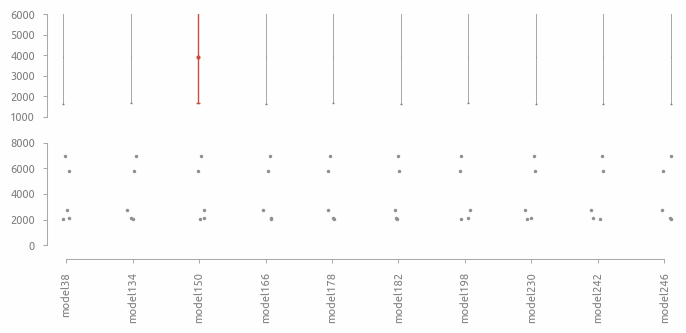

In [112]:
fig, ax = plt.subplots(2, 1, figsize=(8, 3))

ax[0].scatter(
    x = cv1_month_splits_desriptive_top.index,
    y = cv1_month_splits_desriptive_top['mean'],
    s=10)

ax[0].errorbar(
    x = cv1_month_splits_desriptive_top.index,
    y = cv1_month_splits_desriptive_top['mean'],
    yerr = cv1_month_splits_desriptive_top['std'],
    ls='none',
    lw=0.5,
    capsize=1,
    alpha=0.75)

# best model
ax[0].errorbar(
    x = cv1_month_splits_desriptive_top.loc[cv1_month_splits_best_model].name,
    y = cv1_month_splits_desriptive_top.loc[cv1_month_splits_best_model]['mean'],
    yerr = cv1_month_splits_desriptive_top.loc[cv1_month_splits_best_model]['std'],
    ls='none',
    lw=1,
    marker='.',
    markersize=4,
    capsize=1.5,
    color=saturate_color(palette[1], 1.5))

axis_rstyle(ax=ax[0], yticks=[1000, 6000, 1000], ylim=[1000, 6000], offset_left=7)
ax[0].spines['bottom'].set_visible(False)
ax[0].tick_params(bottom=False, labelbottom=False)

sns.stripplot(
    cv1_month_splits_top,
    s=5,
    color=palette[-2],
    ax=ax[1])

axis_rstyle(ax=ax[1], offset_left=7)

plt.xticks(rotation=90)
plt.subplots_adjust(hspace=0.25)

savefig('cv_results_plot', dir_save_img)

In [113]:
# top 5 model smoothed data
cv1_month_splits_top_smoothed = smoothed(cv1_month_splits_top[cv1_month_splits_top_models], n=200)

In [114]:
cv1_month_splits_top_smoothed

,model150,model134,model178,model198,model166,model230,model246,model182,model38,model242
0.000000,2102.238255,2099.537887,2100.610058,2102.185759,2101.829267,2101.132076,2101.080669,2101.560485,2101.922796,2099.086960
0.020101,2113.421189,2110.707357,2111.888721,2113.356525,2113.170145,2112.505238,2112.478239,2112.833269,2113.242078,2110.466221
0.040201,2123.722573,2120.998337,2122.283262,2123.647079,2123.620896,2122.987466,2122.984010,2123.219134,2123.671824,2120.956466
0.060302,2133.166794,2130.435168,2131.818108,2133.081793,2133.206067,2132.603313,2132.622547,2132.742574,2133.236574,2130.582198
0.080402,2141.778242,2139.042189,2140.517685,2141.685040,2141.950200,2141.377334,2141.418417,2141.428085,2141.960869,2139.367921
...,...,...,...,...,...,...,...,...,...,...
3.919598,7059.563196,7060.029151,7060.297520,7059.858683,7065.336680,7066.348195,7066.255364,7066.246888,7066.414576,7071.650143
3.939698,7035.524339,7035.886838,7036.131616,7035.684899,7041.071546,7042.122163,7042.012949,7042.051680,7042.131238,7047.827775
3.959799,7008.561379,7008.818967,7009.037245,7008.583718,7013.869289,7014.959855,7014.833631,7014.922341,7014.909821,7021.081536
3.979899,6978.628255,6978.779480,6978.968288,6978.509049,6983.683642,6984.815013,6984.671143,6984.812652,6984.704045,6991.365329


Images 'cv_models_plot.png' and 'cv_models_plot.svg' successfully saved into 'docs/img/' directory


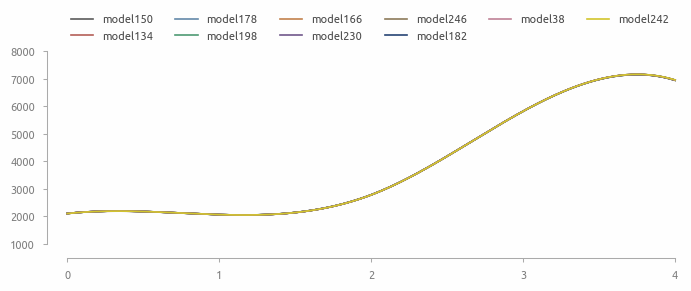

In [115]:
fig = plt.figure()

plt.plot(
    cv1_month_splits_top_smoothed
)
plt.legend(**legend_inline(), labels=cv1_month_splits_top_smoothed.columns);
ax_current().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
axis_rstyle(xticks=[0, 4, 1], offset_left=10)

savefig('cv_models_plot', dir_save_img)

In [116]:
cv1_month_period = train.loc['2017-03-01':'2017-07-30'].groupby('month').mean().copy()

In [117]:
cv1_month_period = train.loc['2017-03-01':'2017-07-30'].groupby('month').agg({'target1': ['mean', 'std']})

In [118]:
cv1_month_period.index = cv1_month_period.index - 3

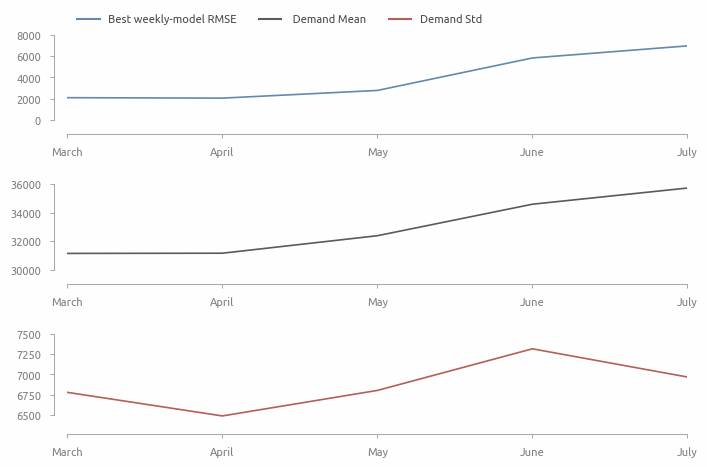

In [119]:
# top model

plt.figure(figsize=(8, 5))

plt.subplot(3, 1, 1)
plt.plot(
    cv1_month_splits_top[cv1_month_splits_best_model],
    color=palette[2],
    label=cv1_month_splits_best_model
)
# ax_current().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
axis_rstyle(xlim=[0, 4], xticks=[0, 4, 1], offset_left=10)
plt.xticks(arange(5), months_list[2:7])
# axis_remove_xaxis()
plt.legend(
    **legend_inline(3),
    **legend_create_handles(
        3,
        labels=['Best weekly-model RMSE', ' Demand Mean', 'Demand Std'],
        colors=[palette[2], palette[0], palette[1]]
    ));
# axis_remove_xaxis()

plt.subplot(3, 1, 2)
plt.plot(
    cv1_month_period['target1']['mean'],
    label='Mean'
)
axis_rstyle(xlim=[0, 4], xticks=[0, 4, 1], yticks=[30000, 36000, 2000], offset_left=10)
plt.xticks(arange(5), months_list[2:7])
# axis_remove_xaxis()

plt.subplot(3, 1, 3)
plt.plot(
    cv1_month_period['target1']['std'],
    color=palette[1],
    label='Std'
)
# ax_current().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
axis_rstyle(xlim=[0, 4], xticks=[0, 4, 1], yticks=[6500, 7500, 250], offset_left=10)

plt.xticks(arange(5), months_list[2:7])
plt.subplots_adjust(hspace=0.75)
plt.show()

In [120]:
train_by_week = train.loc['2017-02-01':].groupby(['month','week'])['target1'].mean().copy()

In [121]:
train_by_week = pd.DataFrame(train_by_week)

In [122]:
train_by_week['xticks'] = arange(len(train_by_week))

In [123]:
train_by_week.head(10)

target1  xticks
month week                      
2     5     30583.559322       0
      6     30620.320823       1
      7     31062.869249       2
      8     31481.355932       3
      9     31265.741525       4
3     9     30746.800000       5
      10    31181.975684       6
      11    31431.003040       7
      12    30691.173252       8
      13    31789.412766       9

In [124]:
months_list

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

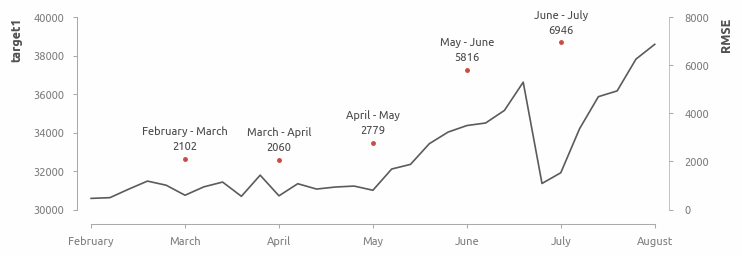

Images 'cv_rmse_plot.png' and 'cv_rmse_plot.svg' successfully saved into 'docs/img/' directory


In [125]:
fig, ax1 = plt.subplots()

ax1.plot(train_by_week['xticks'], train_by_week['target1'])
ax1.set_xticks([0, 5, 10, 15, 20 , 25, 30], months_list[1:8])
ax1.set_ylabel('target1')
axis_rstyle(offset_left=-10, ax=ax1)

ax2 = ax1.twinx()
ax2.scatter(
    x=[5, 10, 15, 20 , 25],
    y=cv1_month_splits_top[cv1_month_splits_best_model],
    color=saturate_color(palette[1], 1.5),
    s=25
)
months_rmse_names = [
    'February - March', 'March - April', 'April - May', 'May - June', 'June - July'
]
for i, j, k in zip(
    [5, 10, 15, 20 , 25],
    cv1_month_splits_top[cv1_month_splits_best_model],
    months_rmse_names):
        ax2.annotate(text=k, xy=(i, j+990),
                     size=8, ha='center')
        ax2.annotate(text=int(round(j, 0)), xy=(i, j+365),
                     size=8, ha='center')

ax2.set_ylim(0, 8000)
ax2.grid(False)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color('#AAAAAA')
ax2.spines[['left', 'bottom']].set_visible(False)
ax2.tick_params(axis='y', direction='out', color='#AAAAAA', size=3)
ax2.tick_params(labelcolor='#808080')
# ax2.spines['right'].set_bounds(0, 0.25)
ax2.spines['right'].set_position(('outward', -10))
ax2.set_yticks(arange(0, 8001, 2000))
ax2.set_ylabel('RMSE')

plt.show()

savefig('cv_rmse_plot', dir_save_img)

In [126]:
cv1_month_splits_top[cv1_month_splits_best_model].diff().round(0).fillna(0).astype(int)

0       0
1     -42
2     719
3    3037
4    1129
Name: model150, dtype: int64

In [127]:
cv1_month_splits_desriptive_top['mean'].sort_values()

model150    3940.751764
model134    3941.446098
model178    3941.454210
model198    3942.030692
model166    3942.413485
model230    3942.521169
model246    3942.593228
model182    3942.624976
model38     3942.823647
model242    3942.922044
Name: mean, dtype: float64

In [128]:
cv1_month_splits_best_model

'model150'

In [129]:
cv1_month_models[cv1_month_splits_best_model]

((4, 1, 2), [144, 72, 48, 36], [3, 2, 2, 3])

#### Check only 3 first folds

For 'calm' data best model is - ((4, 1, 2), [144, 72, 48, 36], [4, 1, 1, 3])

In [130]:
cv1_month_splits_ = cv1_month_splits.iloc[:3, :].copy()

In [131]:
cv1_month_splits_

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,...,model246,model247,model248,model249,model250,model251,model252,model253,model254,model255
0,2141.209691,2223.825393,2210.151980,2223.067808,2052.666621,2115.503357,2102.707255,2109.854159,2133.883996,2201.183992,...,2101.080669,2108.629155,2196.935842,2197.471618,2176.479063,2184.510255,2176.376046,2177.751551,2170.883332,2182.076367
1,2153.798884,2077.102021,2059.467957,2058.906914,2196.794515,2098.098537,2059.109933,2054.328307,2321.148557,2191.175668,...,2060.824191,2054.879881,2190.124971,2190.439577,2126.715430,2119.569698,2126.561508,2126.686483,2127.203985,2119.369038
2,2766.906284,2671.805914,2675.423138,2690.244024,3197.415119,3017.025863,3027.591204,3064.326692,3138.726821,2941.658115,...,2777.432794,2809.180356,2708.114610,2707.789281,2715.259190,2741.113742,2715.459103,2715.110036,2714.376479,2739.392339


In [132]:
cv1_month_splits_.mean().sort_values()

model194    2308.590101
model130    2311.280232
model242    2312.198516
model230    2312.990318
model102    2313.105302
               ...     
model213    2499.978983
model8      2531.253124
model72     2531.255216
model24     2531.255647
model88     2531.257808
Length: 256, dtype: float64

In [232]:
cv1_month_models['model194']

((4, 1, 2), [144, 72, 48, 36], [4, 1, 1, 3])

In [234]:
cv1_month_splits_['model194'].mean()

2308.590100791716

In [134]:
cv1_month_models[cv1_month_splits_best_model]

((4, 1, 2), [144, 72, 48, 36], [3, 2, 2, 3])

In [133]:
cv1_month_splits_[cv1_month_splits_best_model].mean()

2313.925673371938

In [235]:
cv1_month_splits_[cv1_month_splits_best_model]

0    2102.238255
1    2060.310537
2    2779.228229
Name: model150, dtype: float64

#### Final Model

In [135]:
arima1_month = cv1_month_models[cv1_month_splits_best_model]

In [136]:
cv1_month_splits_desriptive_top.loc[cv1_month_splits_best_model]

mean     3940.751764
std      2281.041825
lower    2276.428357
upper    5886.513569
Name: model150, dtype: float64

In [137]:
cv1_month_splits['model149']

0    2111.864854
1    2099.210239
2    2770.690138
3    5902.289703
4    6947.929395
Name: model149, dtype: float64

In [138]:
arima1_month

((4, 1, 2), [144, 72, 48, 36], [3, 2, 2, 3])

### ARIMA with exogs variables

In [139]:
# NULL: non-stationarity
sm.tsa.stattools.adfuller(train.loc['2017-07-01':, 'target1_previous_month'])

(-10.780262352765597,
 2.264652307844371e-19,
 25,
 4438,
 {'1%': -3.4318243322143682,
  '5%': -2.8621914772569323,
  '10%': -2.567116785250736},
 67265.01178270859)

### Forecasts

In [142]:
arima_month_order = arima1_month[0]
arima_month_fourier_period = tuple(arima1_month[1])
arima_month_fourier_order = tuple(arima1_month[2])

In [143]:
print(arima_month_order, arima_month_fourier_period, arima_month_fourier_order)

(4, 1, 2) (144, 72, 48, 36) (3, 2, 2, 3)


#### August forecast

In [144]:
train_august_month = train.loc['2017-07-01':, 'target1'].copy()

In [145]:
train_august_month_exogs_df = train.loc['2017-07-01':, features].copy()

In [146]:
test_august_month = valid['target1'].copy()

In [147]:
test_august_month_exogs_df = valid.loc['2017-08-01':, features].copy()

In [148]:
train_august_month_exogs, test_august_month_exogs = \
    ts_arima_fourier_get_exogs(
        fourier_period=arima_month_fourier_period,
        fourier_order=arima_month_fourier_order,
        train_data=train_august_month,
        test_data=test_august_month)

In [149]:
test_august_month_exogs = test_august_month_exogs.join(
    test_august_month_exogs_df
)

In [150]:
%%time
model_month = fit_model_with_fourier(
    order=arima_month_order,
    fourier_period=arima_month_fourier_period,
    fourier_order=arima_month_fourier_order,
    train_data=train_august_month,
    exog=train_august_month_exogs_df
)

/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


CPU times: user 17.3 s, sys: 1.84 s, total: 19.2 s
Wall time: 14.4 s


In [151]:
forecast_month = model_month.get_forecast(steps=len(test_august_month), exog=test_august_month_exogs)

In [152]:
y_pred = forecast_month.predicted_mean

###### MAE

In [153]:
mean_absolute_error(test_august_month, y_pred)

1638.5716705713091

###### MAPE

In [154]:
mean_absolute_percentage_error(test_august_month, y_pred) * 100

4.642317370103273

###### RMSE

In [155]:
root_mean_squared_error(y_true, y_pred)

2098.100394086504

Images 'forecast_august_plot.png' and 'forecast_august_plot.svg' successfully saved into 'docs/img/' directory


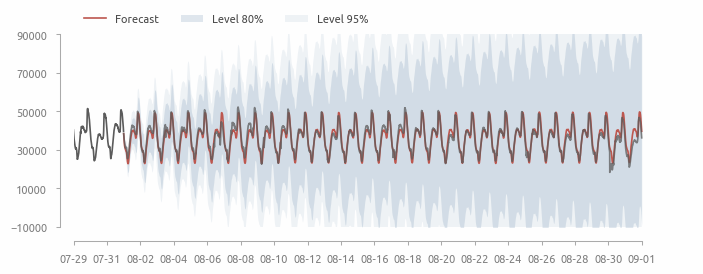

In [156]:
fig = plt.figure()

ts_plot_arima_forecast(
    model=model_month, steps=len(test_august_month),
    data=train_august_month.to_frame(), exog=test_august_month_exogs)
plt.plot(test_august_month, color=palette[0], alpha=0.75)

ax_current().set_xlim(dt.date(2017, 7, 30))
ax_current().set_ylim(-10000, 90000)
ax_current().set_xticks(ticks=pd.date_range(start='2017-07-29', end='2017-09-01', freq='2d'))
ax_current().xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%m-%d'))
axis_rstyle(yticks=[-10000, 100000], offset_left=10)

savefig('forecast_august_plot', dir_save_img)

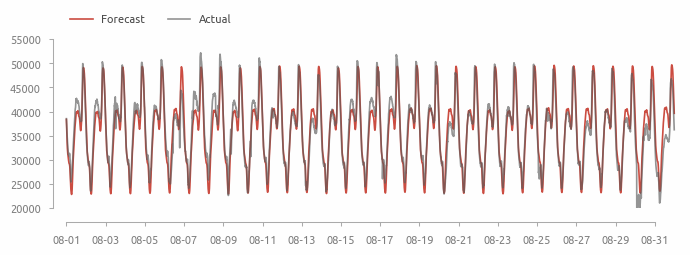

Images 'forecast_august_detailed_plot.png' and 'forecast_august_detailed_plot.svg' successfully saved into 'docs/img/' directory


In [157]:
fig = plt.figure()

plt.plot(
    y_pred.index,
    y_pred,
    label='Forecast',
    color=saturate_color(palette[1], 1.5))

plt.plot(
    valid['target1'],
    label='Actual',
    color=palette[0],
    alpha=0.65);

ax_current().set_xticks(ticks=pd.date_range(start='2017-08-01', end='2017-09-01', freq='2d'))
ax_current().xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%m-%d'))
axis_rstyle(ylim=[20000, 60000])
plt.legend(**legend_inline(bbox_to_anchor=(0, 0.9)))
plt.show()

savefig('forecast_august_detailed_plot', dir_save_img)

In [158]:
print(model_month.summary())

                               SARIMAX Results                                
Dep. Variable:                target1   No. Observations:                 4464
Model:               SARIMAX(4, 1, 2)   Log Likelihood              -33469.638
Date:                Fri, 19 Apr 2024   AIC                          67001.275
Time:                        09:14:27   BIC                          67199.793
Sample:                    07-01-2017   HQIC                         67071.254
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
sin(1,36)               -351.7182     40.590     -8.665      0.000    -431.273    -272.164
cos(1,36)               -824.6400     38.588    -21.370      0.000    -900.271    -749.009
sin(

### Residuals research

In [159]:
resid =  y_pred - y_true

In [160]:
test_normality(resid)

,Test,P or Statistic (s),Condition
0,Kolmogorov-Smirnov,0.0000,Not normal
1,Anderson-Darling (s),7.6407,Not normal
2,Shapiro-Wilk,0.0000,Not normal
3,Jarque-Bera,0.0000,Not normal
4,D’Agostino-Pearson,0.0000,Not normal


In [161]:
np.std(resid)

2093.1987096260673

In [162]:
len(resid)

4464

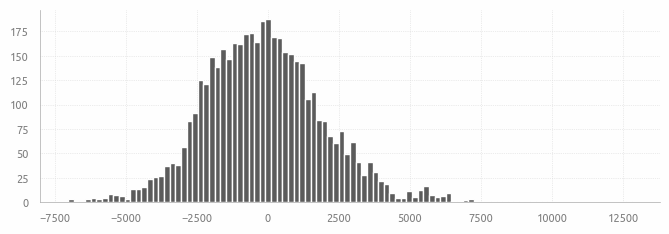

In [163]:
plt.hist(resid, bins=100);

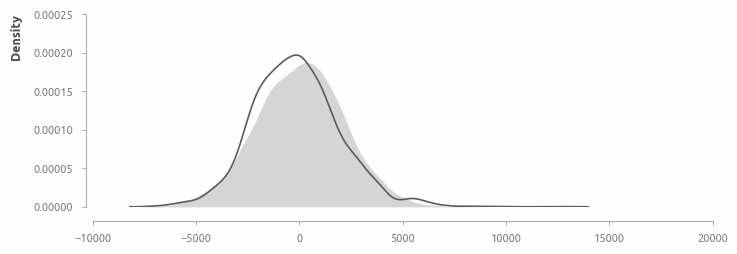

Images 'residuals_distribution_plot.png' and 'residuals_distribution_plot.svg' successfully saved into 'docs/img/' directory


In [164]:
fig = plt.figure()

sns.kdeplot(resid, color=palette[0], label='Residuals');
sns.kdeplot(
    np.random.normal(0, np.std(resid), len(resid)),
    color=palette[0], fill=True, lw=0.01, label='Normal');
axis_rstyle()
plt.show()

savefig('residuals_distribution_plot', dir_save_img)

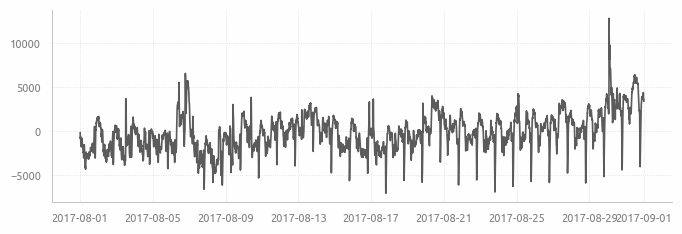

In [165]:
plt.plot(resid);

In [166]:
resid_mean = resid.groupby(resid.index.floor('D')).mean()

In [167]:
resid_mean.sort_values()

2017-08-08   -2544.845189
2017-08-07   -2026.664662
2017-08-17   -1645.436537
2017-08-01   -1643.542761
2017-08-05   -1322.798309
2017-08-16   -1233.114871
2017-08-02   -1199.511273
2017-08-04   -1119.371593
2017-08-09   -1087.988880
2017-08-03   -1081.569238
2017-08-15   -1026.869138
2017-08-18    -842.677279
2017-08-19    -738.894442
2017-08-10    -622.827747
2017-08-23    -533.091057
2017-08-22    -324.714909
2017-08-11    -288.798577
2017-08-24    -283.213104
2017-08-12     195.049703
2017-08-26     203.622392
2017-08-21     210.349810
2017-08-28     232.792826
2017-08-14     312.502499
2017-08-25     446.381617
2017-08-29    1153.477820
2017-08-06    1224.844768
2017-08-27    1308.649483
2017-08-13    1328.494756
2017-08-20    1576.034904
2017-08-30    3306.977438
2017-08-31    3623.420245
dtype: float64

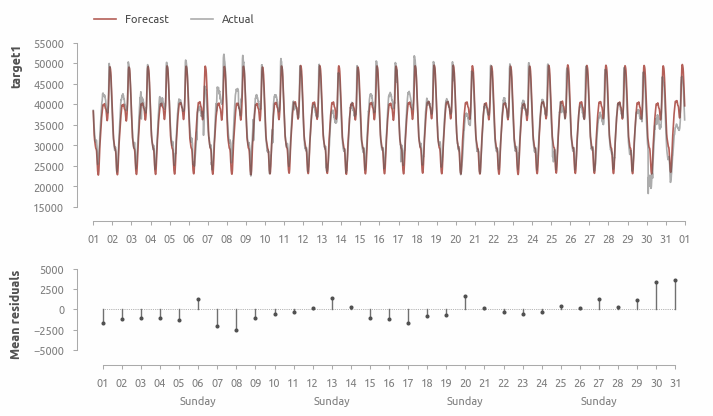

Images 'forecast_august_resid_mean_plot.png' and 'forecast_august_resid_mean_plot.svg' successfully saved into 'docs/img/' directory


In [168]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4), height_ratios=[2, 1])

ax[0].plot(y_pred.index, y_pred, color=palette[1], label='Forecast')
ax[0].plot(y_true.index, y_true, color=palette[0], alpha=0.5, label='Actual')

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%d'))
ax[0].xaxis.set_major_locator(mpl.dates.DayLocator())

ax[0].set_xlim(y_pred.index[0]-dt.timedelta(days=0.5), y_pred.index[-1]+dt.timedelta(days=1))
ax[0].set_ylabel('target1')
axis_rstyle(ax=ax[0])
ax[0].legend(**legend_inline(bbox_to_anchor=(0, 1.05)))

for i in resid_mean.index:
    ax[1].plot([i, i], [0, resid_mean[i]], color=palette[-3], lw=1)
    ax[1].scatter(i, resid_mean[i], s=15, color=palette[-4], zorder=10)

ax[1].plot(
    [resid_mean.index[0], resid_mean.index[-1]],
    [0, 0],
    lw=0.5, ls=':', color=palette[-3])

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%d'))
ax[1].xaxis.set_major_locator(mpl.dates.DayLocator())
ax1_axis_sec =  ax[1].secondary_xaxis('bottom')
ax1_axis_sec.spines['bottom'].set_visible(False)
ax1_axis_sec.tick_params(pad=32, bottom=False, colors='#808080')
ax1_axis_sec.xaxis.set_major_locator(mpl.dates.WeekdayLocator(mpl.dates.SU))
ax1_axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))

ax[1].set_xlim(y_pred.index[0]-dt.timedelta(days=1), y_pred.index[-1]+dt.timedelta(days=0.5))
ax[1].set_ylabel('Mean residuals')

axis_rstyle(xslice=[1, -1], yticks=[-5000, 5000, 2500], ylim=[-5100, 5000], ax=ax[1])

plt.subplots_adjust(hspace=0.5)
plt.show()

savefig('forecast_august_resid_mean_plot', dir_save_img)

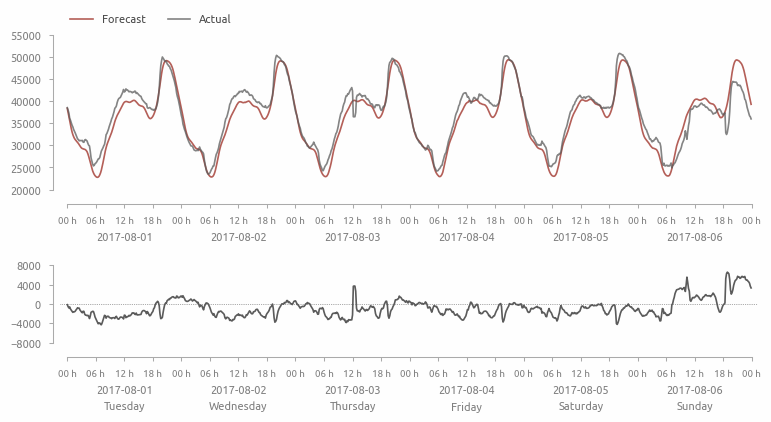

Images 'forecast_august_detail_plot_week1.png' and 'forecast_august_detail_plot_week1.svg' successfully saved into 'docs/img/' directory


In [390]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-01':'2017-08-06'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-01':'2017-08-06'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].legend(**legend_inline())
ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1])


ax[1].plot(resid.loc['2017-08-01':'2017-08-06'])
ax[1].axhline(0, lw=0.5, ls=':')

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_th = axis_secondary(ax=ax[1], pad=42)
axis_th.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
axis_th.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1], yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week1', dir_save_img)

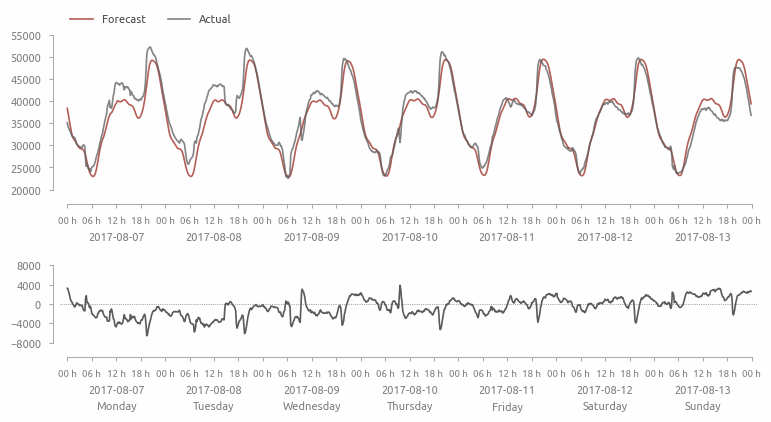

Images 'forecast_august_detail_plot_week2.png' and 'forecast_august_detail_plot_week2.svg' successfully saved into 'docs/img/' directory


In [391]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-07':'2017-08-13'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-07':'2017-08-13'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].legend(**legend_inline())
ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1])


ax[1].plot(resid.loc['2017-08-07':'2017-08-13'])
ax[1].axhline(0, lw=0.5, ls=':')

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_th = axis_secondary(ax=ax[1], pad=42)
axis_th.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
axis_th.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1], yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week2', dir_save_img)

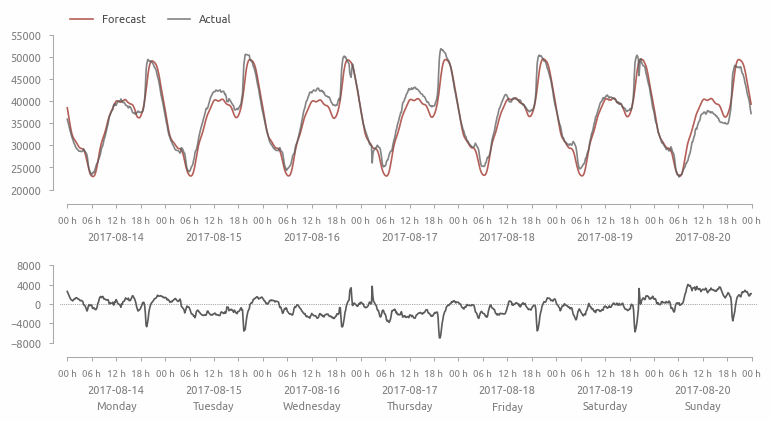

Images 'forecast_august_detail_plot_week3.png' and 'forecast_august_detail_plot_week3.svg' successfully saved into 'docs/img/' directory


In [392]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-14':'2017-08-20'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-14':'2017-08-20'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].legend(**legend_inline())
ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1])


ax[1].plot(resid.loc['2017-08-14':'2017-08-20'])
ax[1].axhline(0, lw=0.5, ls=':')

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_th = axis_secondary(ax=ax[1], pad=42)
axis_th.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
axis_th.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1], yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week3', dir_save_img)

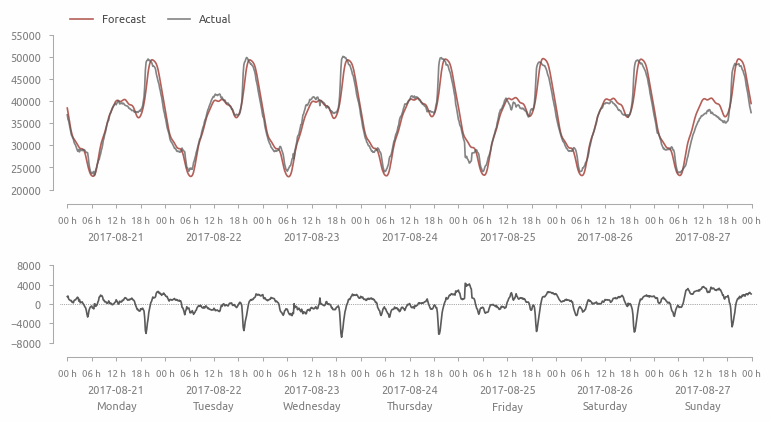

Images 'forecast_august_detail_plot_week4.png' and 'forecast_august_detail_plot_week4.svg' successfully saved into 'docs/img/' directory


In [393]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-21':'2017-08-27'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-21':'2017-08-27'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].legend(**legend_inline())
ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1])


ax[1].plot(resid.loc['2017-08-21':'2017-08-27'])
ax[1].axhline(0, lw=0.5, ls=':')

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_th = axis_secondary(ax=ax[1], pad=42)
axis_th.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
axis_th.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1], yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week4', dir_save_img)

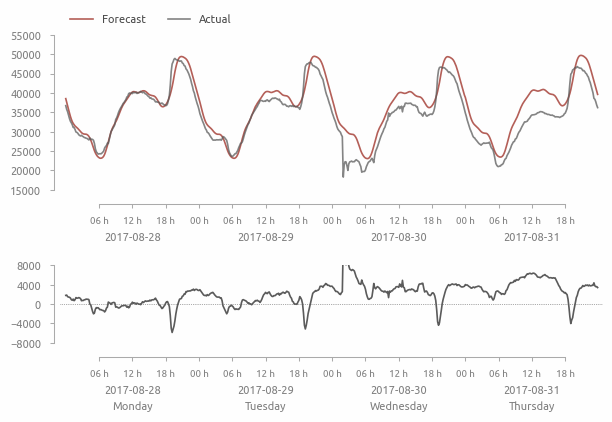

Images 'forecast_august_detail_plot_week5.png' and 'forecast_august_detail_plot_week5.svg' successfully saved into 'docs/img/' directory


In [394]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-28':'2017-08-31'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-28':'2017-08-31'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].legend(**legend_inline())
ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1])


ax[1].plot(resid.loc['2017-08-28':'2017-08-31'])
ax[1].axhline(0, lw=0.5, ls=':')

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_th = axis_secondary(ax=ax[1], pad=42)
axis_th.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
axis_th.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1], yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week5', dir_save_img)

## Boosting Strategies

Predict sepaartely:
- Predict: Residuals
- Predict: First Residual and then Residuals Diff (and after that predict all residuals series)
- Predict: Residuals rolling window

Crate ensemble of boosters.

## Detailed CV Research

In [433]:
def cv_single_model(model, data, target, features, indexes_train, indexes_valid):

    forecast_df = pd.DataFrame()
    iteration = 0

    for train_idx, valid_idx in zip(indexes_train, indexes_valid):
    
        train_target = data.loc[train_idx, target].copy()
        valid_target = data.loc[valid_idx, target].copy()
    
        train_w_fourier, valid_w_fourier = \
            ts_arima_fourier_get_exogs(
                fourier_period=model[1],
                fourier_order=model[2],
                train_data=train_target,
                test_data=valid_target)
    
        train_w_features = data.loc[train_idx, features].copy()
        valid_w_features = data.loc[valid_idx, features].copy()
        
        train_final = train_w_fourier.join(train_w_features)
        valid_final = valid_w_fourier.join(valid_w_features)
    
        model_fitted = fit_model_with_fourier(
            order=model[0],
            fourier_period=model[1],
            fourier_order=model[2],
            data=train_target,
            data_exog=train_final)
    
        forecast = \
            model_fitted.get_forecast(steps=len(valid_target), exog=valid_final)

        y_true = valid_target
        y_pred = forecast.predicted_mean
        residuals = y_pred - y_true
        residuals_diff = residuals.diff()

        forecast_df_local = pd.DataFrame(
            data={
                'true': y_true,
                'pred': y_pred,
                'residuals': residuals,
                'residuals_diff': residuals_diff},
            index=y_true.index)

        forecast_df = pd.concat([forecast_df, forecast_df_local], axis=0)

        print(
            '\n' \
            f'Iteration {iteration}:' '\n' \
            f'Train data: {train_idx[0].strftime('%Y-%m')}' '\n' \
            f'Valid data: {valid_idx[0].strftime('%Y-%m')}' '\n')

        iteration +=1

    clear_output()

    return forecast_df

In [434]:
%%time
cv1_single_model = cv_single_model(
    model=(arima_month_order, arima_month_fourier_period, arima_month_fourier_order),
    data=train,
    target='target1',
    features=features,
    indexes_train=cv1_indexes_train,
    indexes_valid=cv1_indexes_test)

CPU times: user 1min 40s, sys: 9.6 s, total: 1min 50s
Wall time: 1min 1s


In [435]:
cv1_single_model

,true,pred,residuals,residuals_diff
2017-03-01 00:00:00,29069.61702,29019.953420,-49.663600,NaN
2017-03-01 00:10:00,28579.40426,28326.438886,-252.965374,-203.301774
2017-03-01 00:20:00,27844.08511,27634.836898,-209.248212,43.717162
2017-03-01 00:30:00,27237.44681,26945.438220,-292.008590,-82.760378
2017-03-01 00:40:00,26882.04255,26224.594366,-657.448184,-365.439595
...,...,...,...,...
2017-07-31 23:10:00,43407.30897,39147.248672,-4260.060298,254.766608
2017-07-31 23:20:00,42507.90698,38707.448555,-3800.458425,459.601874
2017-07-31 23:30:00,41659.53488,38264.601378,-3394.933502,405.524922
2017-07-31 23:40:00,40843.05648,37766.709248,-3076.347232,318.586270


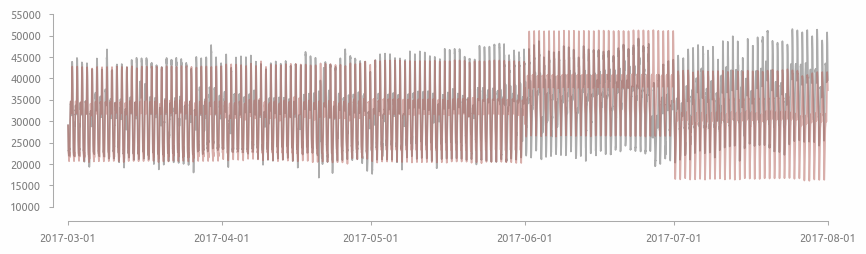

In [347]:
plt.figure(figsize=(10,2.5))
plt.plot(
    cv1_single_model.loc['2017-03-01':, 'true'], color=palette[0], alpha=0.5
)
plt.plot(
    cv1_single_model.loc[:, 'pred'], color=palette[1], alpha=0.5
)
axis_rstyle()

Images 'cv_results_close1.png' and 'cv_results_close1.svg' successfully saved into 'docs/img/' directory


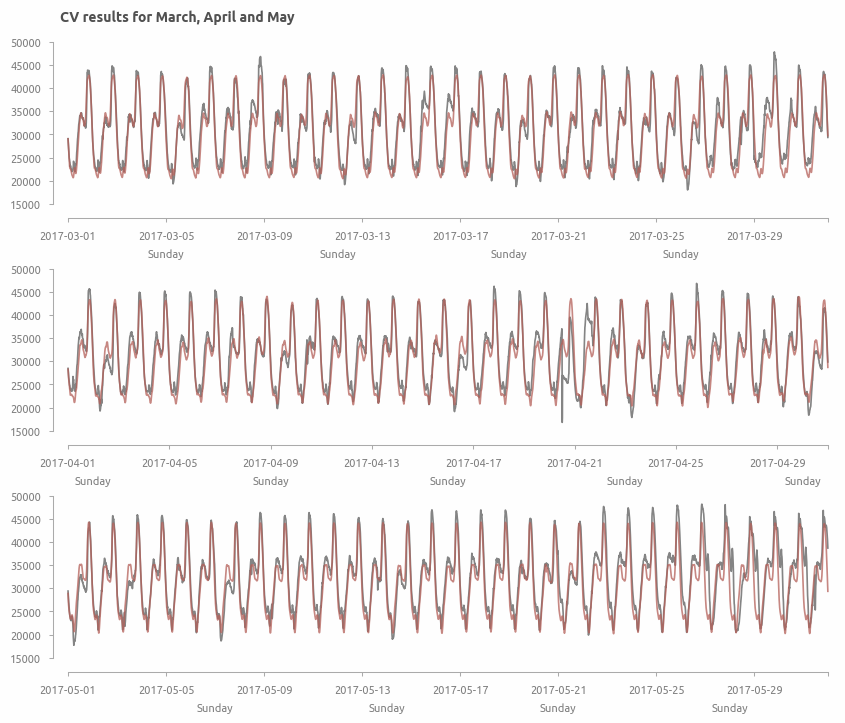

In [351]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

ax[0].set_title('CV results for March, April and May')

ax[0].plot(
    cv1_single_model.loc['2017-03-01':'2017-03-31', 'true'], color=palette[0], alpha=0.75)
ax[0].plot(
    cv1_single_model.loc['2017-03-01':'2017-03-31', 'pred'], color=palette[1], alpha=0.75)
axis_rstyle(ax=ax[0])
ax0_sec = axis_secondary(ax=ax[0])
ax0_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
ax0_sec.xaxis.set_major_locator(mpl.dates.WeekdayLocator(byweekday=mpl.dates.SU))
ax[0].xaxis.get_major_ticks()[-1].label1.set_visible(False)

ax[1].plot(
    cv1_single_model.loc['2017-04-01':'2017-04-30', 'true'], color=palette[0], alpha=0.75)
ax[1].plot(
    cv1_single_model.loc['2017-04-01':'2017-04-30', 'pred'], color=palette[1], alpha=0.75)
axis_rstyle(ax=ax[1])
ax1_sec = axis_secondary(ax=ax[1])
ax1_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
ax1_sec.xaxis.set_major_locator(mpl.dates.WeekdayLocator(byweekday=mpl.dates.SU))
ax[1].xaxis.get_major_ticks()[-1].label1.set_visible(False)

ax[2].plot(
    cv1_single_model.loc['2017-05-01':'2017-05-31', 'true'], color=palette[0], alpha=0.75)
ax[2].plot(
    cv1_single_model.loc['2017-05-01':'2017-05-31', 'pred'], color=palette[1], alpha=0.75)
axis_rstyle(ax=ax[2])
ax2_sec = axis_secondary(ax=ax[2])
ax2_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
ax2_sec.xaxis.set_major_locator(mpl.dates.WeekdayLocator(byweekday=mpl.dates.SU))
ax[2].xaxis.get_major_ticks()[-1].label1.set_visible(False)

plt.subplots_adjust(hspace=0.4)

savefig('cv_results_close1', dir_save_img)

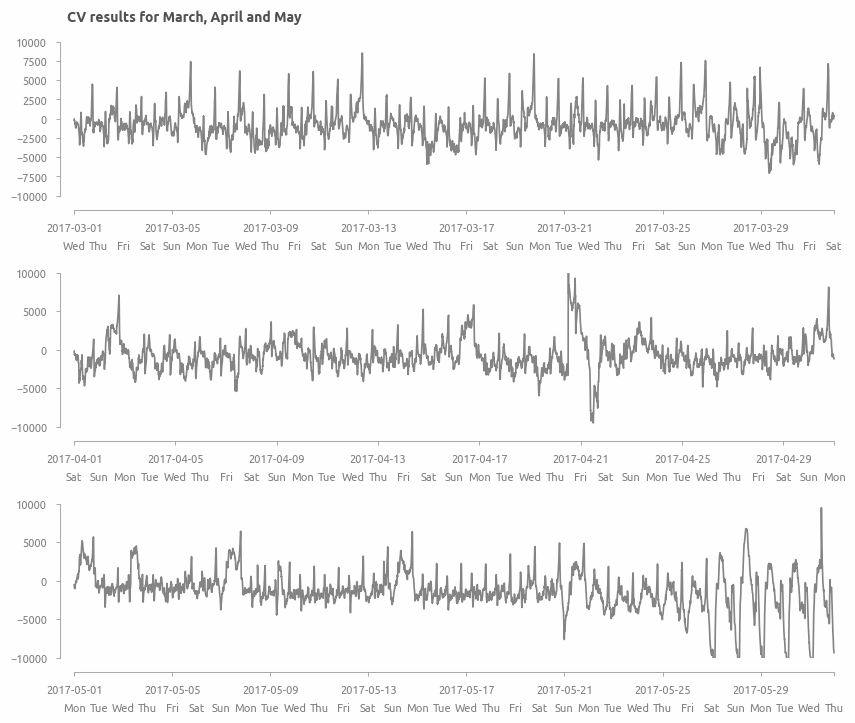

Images 'cv_results_close2.png' and 'cv_results_close2.svg' successfully saved into 'docs/img/' directory


In [404]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

ax[0].set_title('CV results for March, April and May')

ax[0].plot(
    cv1_single_model.loc['2017-03-01':'2017-03-31', 'residuals'], color=palette[0], alpha=0.75)
axis_rstyle(ax=ax[0], ylim=[-10000, 10000, 2000])
ax0_sec = axis_secondary(ax=ax[0])
ax0_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%a'))
ax0_sec.xaxis.set_major_locator(mpl.dates.DayLocator())
ax[0].xaxis.get_major_ticks()[-1].label1.set_visible(False)

ax[1].plot(
    cv1_single_model.loc['2017-04-01':'2017-04-30', 'residuals'], color=palette[0], alpha=0.75)
axis_rstyle(ax=ax[1], ylim=[-10000, 10000, 2000])
ax1_sec = axis_secondary(ax=ax[1])
ax1_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%a'))
ax1_sec.xaxis.set_major_locator(mpl.dates.DayLocator())
ax[1].xaxis.get_major_ticks()[-1].label1.set_visible(False)

ax[2].plot(
    cv1_single_model.loc['2017-05-01':'2017-05-31', 'residuals'], color=palette[0], alpha=0.75)
axis_rstyle(ax=ax[2], ylim=[-10000, 10000, 2000])
ax2_sec = axis_secondary(ax=ax[2])
ax2_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%a'))
ax2_sec.xaxis.set_major_locator(mpl.dates.DayLocator())
ax[2].xaxis.get_major_ticks()[-1].label1.set_visible(False)

plt.subplots_adjust(hspace=0.5)
plt.show()

savefig('cv_results_close2', dir_save_img)

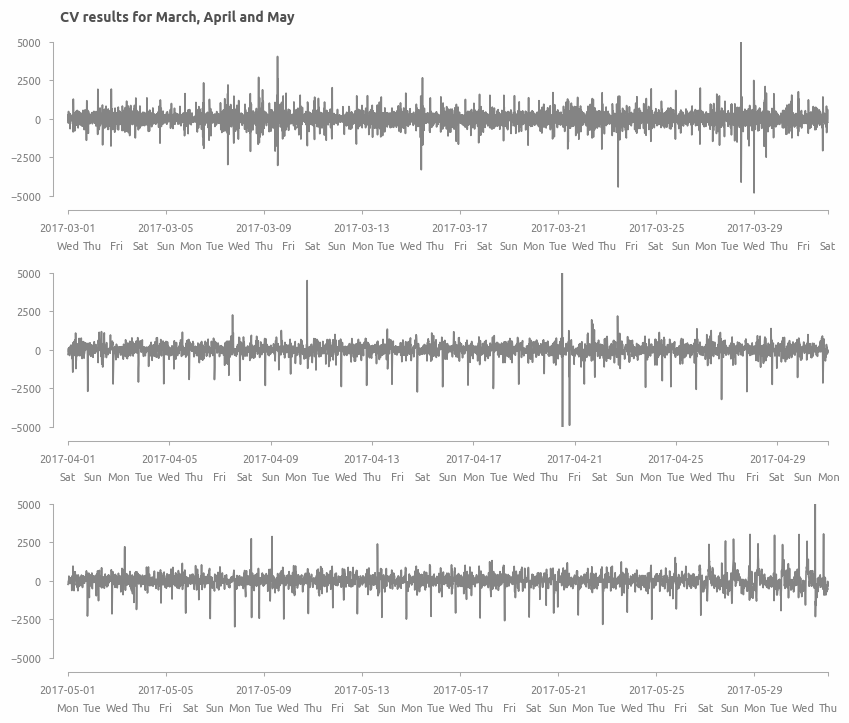

In [436]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

ax[0].set_title('CV results for March, April and May')

ax[0].plot(
    cv1_single_model.loc['2017-03-01':'2017-03-31', 'residuals_diff'], color=palette[0], alpha=0.75)
axis_rstyle(ax=ax[0], yticks=[-5000, 5000, 2500], ylim=[-5000, 5000])
ax0_sec = axis_secondary(ax=ax[0])
ax0_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%a'))
ax0_sec.xaxis.set_major_locator(mpl.dates.DayLocator())
ax[0].xaxis.get_major_ticks()[-1].label1.set_visible(False)

ax[1].plot(
    cv1_single_model.loc['2017-04-01':'2017-04-30', 'residuals_diff'], color=palette[0], alpha=0.75)
axis_rstyle(ax=ax[1], yticks=[-5000, 5000, 2500], ylim=[-5000, 5000])
ax1_sec = axis_secondary(ax=ax[1])
ax1_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%a'))
ax1_sec.xaxis.set_major_locator(mpl.dates.DayLocator())
ax[1].xaxis.get_major_ticks()[-1].label1.set_visible(False)

ax[2].plot(
    cv1_single_model.loc['2017-05-01':'2017-05-31', 'residuals_diff'], color=palette[0], alpha=0.75)
axis_rstyle(ax=ax[2], yticks=[-5000, 5000, 2500], ylim=[-5000, 5000])
ax2_sec = axis_secondary(ax=ax[2])
ax2_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%a'))
ax2_sec.xaxis.set_major_locator(mpl.dates.DayLocator())
ax[2].xaxis.get_major_ticks()[-1].label1.set_visible(False)

plt.subplots_adjust(hspace=0.5)
plt.show()

# savefig('cv_results_close2', dir_save_img)

In [444]:
cv1_single_model.loc['2017-03-01':'2017-03-10', 'residuals_diff'].rolling(2).sum()

2017-03-01 00:00:00           NaN
2017-03-01 00:10:00           NaN
2017-03-01 00:20:00   -159.584612
2017-03-01 00:30:00    -39.043216
2017-03-01 00:40:00   -448.199972
                          ...    
2017-03-10 23:10:00   -351.727229
2017-03-10 23:20:00   -344.346257
2017-03-10 23:30:00     94.466617
2017-03-10 23:40:00    122.079790
2017-03-10 23:50:00    -98.579240
Freq: 10min, Name: residuals_diff, Length: 1440, dtype: float64

In [441]:
cv1_single_model.loc['2017-03-01':'2017-03-10', 'residuals_diff']

2017-03-01 00:00:00           NaN
2017-03-01 00:10:00   -203.301774
2017-03-01 00:20:00     43.717162
2017-03-01 00:30:00    -82.760378
2017-03-01 00:40:00   -365.439595
                          ...    
2017-03-10 23:10:00   -356.586730
2017-03-10 23:20:00     12.240473
2017-03-10 23:30:00     82.226144
2017-03-10 23:40:00     39.853646
2017-03-10 23:50:00   -138.432886
Freq: 10min, Name: residuals_diff, Length: 1440, dtype: float64

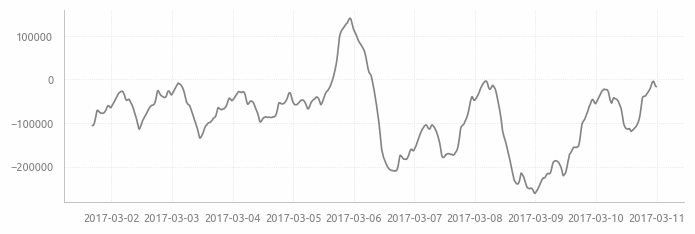

In [452]:
plt.plot(
    cv1_single_model.loc['2017-03-01':'2017-03-10', 'residuals'].rolling(100).sum(), color=palette[0], alpha=0.75)

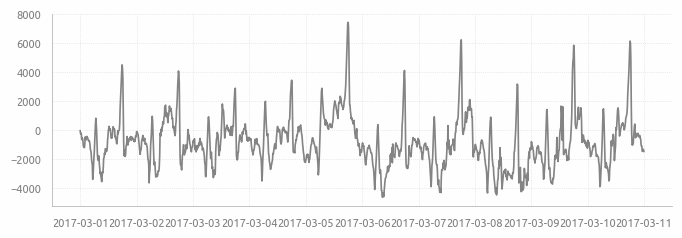

In [450]:
plt.plot(
    cv1_single_model.loc['2017-03-01':'2017-03-10', 'residuals'], color=palette[0], alpha=0.75)

In [448]:
cv1_single_model

,true,pred,residuals,residuals_diff
2017-03-01 00:00:00,29069.61702,29019.953420,-49.663600,NaN
2017-03-01 00:10:00,28579.40426,28326.438886,-252.965374,-203.301774
2017-03-01 00:20:00,27844.08511,27634.836898,-209.248212,43.717162
2017-03-01 00:30:00,27237.44681,26945.438220,-292.008590,-82.760378
2017-03-01 00:40:00,26882.04255,26224.594366,-657.448184,-365.439595
...,...,...,...,...
2017-07-31 23:10:00,43407.30897,39147.248672,-4260.060298,254.766608
2017-07-31 23:20:00,42507.90698,38707.448555,-3800.458425,459.601874
2017-07-31 23:30:00,41659.53488,38264.601378,-3394.933502,405.524922
2017-07-31 23:40:00,40843.05648,37766.709248,-3076.347232,318.586270


In [428]:
cv1_single_model['residuals_diff'] = cv1_single_model.loc[:, 'residuals'].diff()

In [414]:
a = cv1_single_model.loc['2017-03-01':'2017-03-31', 'residuals'][1:] - cv1_single_model.loc['2017-03-01':'2017-03-31', 'residuals'].diff()

In [415]:
a

2017-03-01 00:00:00           NaN
2017-03-01 00:10:00    -49.663600
2017-03-01 00:20:00   -252.965374
2017-03-01 00:30:00   -209.248212
2017-03-01 00:40:00   -292.008590
                          ...    
2017-03-31 23:10:00    501.242048
2017-03-31 23:20:00    234.279357
2017-03-31 23:30:00    -24.475755
2017-03-31 23:40:00    312.047147
2017-03-31 23:50:00    456.376600
Freq: 10min, Name: residuals, Length: 4464, dtype: float64

## Save Data

### Save Session

In [192]:
save_session(session_name)

### Execution time

In [193]:
print(f'Execution time: {stopwatch.stop(start)}')

Execution time: 0:06:07
